In [77]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib import cm

In [78]:
sampling_methods = ['test_query', 'uncertainty', "AV_temperature", "active_query", "Core_set", 'certainty', 'OpenMax', 'BGADL', 'random', "BADGE_sampling"]
datasets = {'Tiny-Imagenet': {'init_percent': 8, 'known_class': [40], 'batch': [400]},
            'cifar100': {'init_percent': 8, 'known_class': [20], 'batch': [400]},
            'cifar10': {'init_percent': 1, 'known_class': [2], 'batch': [400]}}

In [79]:
def load_pkl_files(dataset_name, known_class, batch_size=None):
    pkl_files = {method: [] for method in sampling_methods}
    log_al_folder = 'log_AL/'
    for file in os.listdir(log_al_folder):
        if file.endswith('.pkl') and f"{dataset_name}_" in file and f"known{known_class}" in file:
            if batch_size is not None and f"batch{batch_size}_" not in file:
                continue
            for method in sampling_methods:
                if "hybrid_" in file:
                    if method in file:
                        if "_per_round_query_index" in file:
                            continue
                        pkl_files[method].append(os.path.join(log_al_folder, file))
                        break
    return pkl_files

In [80]:
def plot_graphs(group_name, acc_list, precision_list, recall_list, acc_std_list, precision_std_list, recall_std_list, batch_size):

    dataset_name_map = {"Tiny-Imagenet": "Tiny-Imagenet",
                        "cifar10": "CIFAR10",
                        "cifar100": "CIFAR100"}
    method_colors = {sampling_methods[i]: plt.cm.tab10(i) for i in range(len(sampling_methods))}
    method_colors['Proposed'] = method_colors['active_query']
    width_map = {}
    for item in sampling_methods:
        if item not in width_map:
            width_map[item] = 1
            if item == 'active_query':
                width_map[item] = 2
            if item == 'test_query':
                width_map[item] = 2
    width_map['Proposed'] = 2
    # Accuracy plot
    query_numbers = list(range(len(acc_list[0])))

    fig, ax = plt.subplots(figsize=(7.5, 6))
    for i, (acc, acc_std) in enumerate(zip(acc_list, acc_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'

        ax.plot(query_numbers, acc, label=label, color=method_colors[label], linewidth=width_map[label])
        ax.fill_between(query_numbers, np.array(acc) - 0.8 * np.array(acc_std), np.array(acc) + 0.8 * np.array(acc_std), alpha=0.2, color=method_colors[label])

    for tick in ax.get_yticks():
        ax.axhline(tick, linestyle='dashed', alpha=0.2, color='red')

    ax.xaxis.set_ticks(range(len(query_numbers)))
    for tick in ax.get_xticks():
        ax.axvline(tick, linestyle='dashed', alpha=0.2, color='red')

    ax.set_xlabel('Query Round', fontsize=22)
    ax.set_ylabel('Accuracy (%)', fontsize=22)
    ax.set_title(f'{dataset_name_map[group_name.split()[0]]}    Batch Size: {batch_size}', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)




    if group_name == "Tiny-Imagenet Known 40 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3)
        half_length = len(query_numbers) // 2
        for i, (acc, acc_std) in enumerate(zip(acc_list, acc_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
            if label == 'test_query' or label == 'Proposed':
                if label == 'Proposed':
                    label = "active_query"
                ax_inset.plot(query_numbers[half_length:], acc[half_length:], label=label, color=method_colors[label], linewidth=width_map[label])
                ax_inset.fill_between(query_numbers[half_length:],
                                      np.array(acc[half_length:]) - 0.8 * np.array(acc_std[half_length:]),
                                      np.array(acc[half_length:]) + 0.8 * np.array(acc_std[half_length:]), alpha=0.2,
                                      color=method_colors[label])

        ax_inset.set_xlim(7.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(42.5, 42.5 + 8)  # Set y-axis range from 36 to 42
        ax_inset.xaxis.set_ticklabels([])  # Remove x-axis numbers
        # ax_inset.yaxis.set_ticklabels([]) # Remove x-axis numbers
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)
    if group_name == "cifar100 Known 20 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3)
        half_length = len(query_numbers) // 2
        for i, (acc, acc_std) in enumerate(zip(acc_list, acc_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
            if label == 'test_query' or label == 'Proposed':
                if label == 'Proposed':
                    label = "active_query"
                ax_inset.plot(query_numbers[half_length:], acc[half_length:], label=label, color=method_colors[label], linewidth=width_map[label])
                ax_inset.fill_between(query_numbers[half_length:],
                                      np.array(acc[half_length:]) - 0.8 * np.array(acc_std[half_length:]),
                                      np.array(acc[half_length:]) + 0.8 * np.array(acc_std[half_length:]), alpha=0.2,
                                      color=method_colors[label])

        ax_inset.set_xlim(7.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(57.5, 57.5 + 8)  # Set y-axis range from 36 to 42
        ax_inset.xaxis.set_ticklabels([])  # Remove x-axis numbers
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        # ax_inset.yaxis.set_ticklabels([]) # Remove x-axis numbers
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)

    if group_name == "cifar10 Known 2 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3.0)
        half_length = len(query_numbers) // 2
        for i, (acc, acc_std) in enumerate(zip(acc_list, acc_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
            if label == 'Proposed':
                label = "active_query"
            ax_inset.plot(query_numbers[half_length:], acc[half_length:], label=label, color=method_colors[label], linewidth=width_map[label])
            ax_inset.fill_between(query_numbers[half_length:],
                                  np.array(acc[half_length:]) - 0.8 * np.array(acc_std[half_length:]),
                                  np.array(acc[half_length:]) + 0.8 * np.array(acc_std[half_length:]), alpha=0.2,
                                  color=method_colors[label])

        ax_inset.set_xlim(7.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(93.5, 92.5 + 6)  # Set y-axis range from 92.5 to 100.5
        ax_inset.xaxis.set_ticklabels([])  # Remove x-axis numbers
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)
    plt.savefig(f'baseline/{group_name.split()[0]} Batch {batch_size} baseline acc.png', format='png', dpi=300)
    plt.show()

    # plot precision

    fig, ax = plt.subplots(figsize=(7.5, 6))
    for i, (precision, precision_std) in enumerate(zip(precision_list, precision_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
        ax.plot(query_numbers, np.array(precision) * 100, label=label, color=method_colors[label], linewidth=width_map[label])
        ax.fill_between(query_numbers, (np.array(precision) - 0.8 * np.array(precision_std)) * 100,
                        (np.array(precision) + 0.8 * np.array(precision_std)) * 100, alpha=0.2,
                        color=method_colors[label])

    for tick in ax.get_yticks():
        ax.axhline(tick, linestyle='dashed', alpha=0.2, color='blue')

    ax.xaxis.set_ticks(range(len(query_numbers)))

    for tick in ax.get_xticks():
        ax.axvline(tick, linestyle='dashed', alpha=0.2, color='blue')

    ax.set_xlabel('Query Round', fontsize=22)
    ax.set_ylabel('Precision (%)', fontsize=22)
    ax.set_title(f'{dataset_name_map[group_name.split()[0]]}    Batch Size: {batch_size}', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylim(0, 100)


    if group_name == "Tiny-Imagenet Known 40 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3)
        half_length = len(query_numbers) // 2
        for i, (precision, precision_std) in enumerate(zip(precision_list, precision_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
            if label == 'test_query' or label == 'Proposed':
                if label == 'Proposed':
                    label = "active_query"
                ax_inset.plot(query_numbers[half_length:], np.array(precision[half_length:]) * 100, label=label, color=method_colors[label], linewidth=width_map[label])
                ax_inset.fill_between(query_numbers[half_length:], (np.array(precision[half_length:]) - 0.8 * np.array(precision_std[half_length:])) * 100, (np.array(precision[half_length:]) + 0.8 * np.array(precision_std[half_length:])) * 100, alpha=0.2, color=method_colors[label])

        ax_inset.set_xlim(6.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(80, 80 + 12)  # Set y-axis range from 70 to 90
        ax_inset.xaxis.set_ticklabels([])  # Remove x-axis numbers
        ax_inset.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_inset.yaxis.set_major_locator(MultipleLocator(4))
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        # ax_inset.yaxis.set_ticklabels([])  # Remove x-axis numbers
        # ax_inset.set_xlabel('Query Numbers')
        # ax_inset.set_ylabel('Precision (%)')
                # Make tick marks invisible
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)


    if group_name == "cifar100 Known 20 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3)
        half_length = len(query_numbers) // 2
        for i, (precision, precision_std) in enumerate(zip(precision_list, precision_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
            if label == 'test_query' or label == 'Proposed':
                if label == 'Proposed':
                    label = "active_query"
                ax_inset.plot(query_numbers[half_length:], np.array(precision[half_length:]) * 100, label=label, color=method_colors[label], linewidth=width_map[label])
                ax_inset.fill_between(query_numbers[half_length:], (np.array(precision[half_length:]) - 0.8 * np.array(precision_std[half_length:])) * 100, (np.array(precision[half_length:]) + 0.8 * np.array(precision_std[half_length:])) * 100, alpha=0.2, color=method_colors[label])

        ax_inset.set_xlim(6.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(78, 80 + 12)  # Set y-axis range from 70 to 90
        ax_inset.xaxis.set_ticklabels([])  # Remove x-axis numbers
        ax_inset.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_inset.yaxis.set_major_locator(MultipleLocator(4))
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        # ax_inset.yaxis.set_ticklabels([])  # Remove x-axis numbers
        # ax_inset.set_xlabel('Query Numbers')
        # ax_inset.set_ylabel('Precision (%)')
                # Make tick marks invisible
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)

    if group_name == "cifar10 Known 2 Batch 400":
        # Create an inset axis
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left', borderpad=3.0)
        half_length = len(query_numbers) // 2
        for i, (precision, precision_std) in enumerate(zip(precision_list, precision_std_list)):
            label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'

            if label == 'Proposed':
                label = "active_query"
            ax_inset.plot(query_numbers[half_length:], np.array(precision[half_length:]) * 100, label=label, color=method_colors[label], linewidth=width_map[label])
            ax_inset.fill_between(query_numbers[half_length:], (np.array(precision[half_length:]) - 0.8 * np.array(precision_std[half_length:])) * 100, (np.array(precision[half_length:]) + 0.8 * np.array(precision_std[half_length:])) * 100, alpha=0.2, color=method_colors[label])

        ax_inset.set_xlim(6.0, query_numbers[-1])  # Set x-axis from 6.0 to the end
        ax_inset.set_ylim(82, 82 + 18)  # Set y-axis range from 82 to 100
        ax_inset.xaxis.set_ticklabels([])

        ax_inset.set_yticks([82, 88, 94, 100])
        ax_inset.set_yticklabels(['82', '88', '94', '100'])

        ax_inset.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_inset.yaxis.set_major_locator(MultipleLocator(4))
        ax_inset.tick_params(axis='both', which='major', labelsize=16)
        # ax_inset.yaxis.set_ticklabels([])  # Remove x-axis numbers
        # ax_inset.set_xlabel('Query Numbers')
        # ax_inset.set_ylabel('Precision (%)')
                # Make tick marks invisible
        for tic in ax_inset.xaxis.get_major_ticks() + ax_inset.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)
    plt.savefig(f'baseline/{group_name.split()[0]} Batch {batch_size} baseline precision.png', format='png', dpi=300)
    plt.show()

    fig, ax = plt.subplots(figsize=(7.5, 6))
    for i, (recall, recall_std) in enumerate(zip(recall_list, recall_std_list)):
        label = sampling_methods[i] if sampling_methods[i] != 'active_query' else 'Proposed'
        ax.plot(query_numbers, np.array(recall) * 100, label=label, color=method_colors[label], linewidth=width_map[label])
        ax.fill_between(query_numbers, (np.array(recall) - 0.8 * np.array(recall_std)) * 100,
                        (np.array(recall) + 0.8 * np.array(recall_std)) * 100, alpha=0.2, color=method_colors[label])

    for tick in ax.get_yticks():
        ax.axhline(tick, linestyle='dashed', alpha=0.2, color='green')

    ax.xaxis.set_ticks(range(len(query_numbers)))
    for tick in ax.get_xticks():
        ax.axvline(tick, linestyle='dashed', alpha=0.2, color='green')

    ax.set_xlabel('Query Round', fontsize=22)
    ax.set_ylabel('Recall (%)', fontsize=22)
    ax.set_title(f'{dataset_name_map[group_name.split()[0]]}    Batch Size: {batch_size}', fontsize=22)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.savefig(f'baseline/{group_name.split()[0]} Batch {batch_size} baseline recall.png', format='png', dpi=300)
    plt.show()


In [81]:
def plot_legend(sampling_methods):
    # Replace the labels
    sampling_methods = ['NEAT' if method == 'active_query' else method for method in sampling_methods]
    sampling_methods = ['NEAT (Passive)' if method == 'test_query' else method for method in sampling_methods]
    sampling_methods = ['LFOSA' if method == 'AV_temperature' else method for method in sampling_methods]
    sampling_methods = ['CORESET' if method == 'Core_set' else method for method in sampling_methods]
    sampling_methods = ['RANDOM' if method == 'random' else method for method in sampling_methods]
    sampling_methods = ['UNCERTAINTY' if method == 'uncertainty' else method for method in sampling_methods]
    sampling_methods = ['CERTAINTY' if method == 'certainty' else method for method in sampling_methods]
    sampling_methods = ['OPENMAX' if method == 'OpenMax' else method for method in sampling_methods]

    method_colors = {sampling_methods[i]: plt.cm.tab10(i) for i in range(len(sampling_methods))}
    method_colors['NEAT'] = method_colors['active_query'] if 'active_query' in method_colors else method_colors['NEAT']

    # Reorder legend elements
    desired_order = ['NEAT', 'NEAT (Passive)', 'LFOSA']
    other_methods = [method for method in sampling_methods if method not in desired_order]
    ordered_sampling_methods = desired_order + other_methods

    # Create a separate legend plot
    legend_elements = [patches.Patch(color=method_colors[method], label=method) for method in ordered_sampling_methods]

    fig, ax = plt.subplots(figsize=(10, 2.4))  # Adjust the figsize to 640x480 pixels
    ax.legend(handles=legend_elements, loc='center', ncol=5, bbox_to_anchor=(0.5, 0.5))
    ax.axis('off')
    plt.savefig(f'baseline/baseline_legend.png', format='png', dpi=300)
    plt.show()

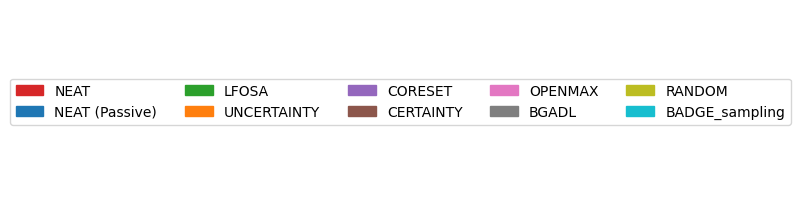

In [82]:
plot_legend(sampling_methods)

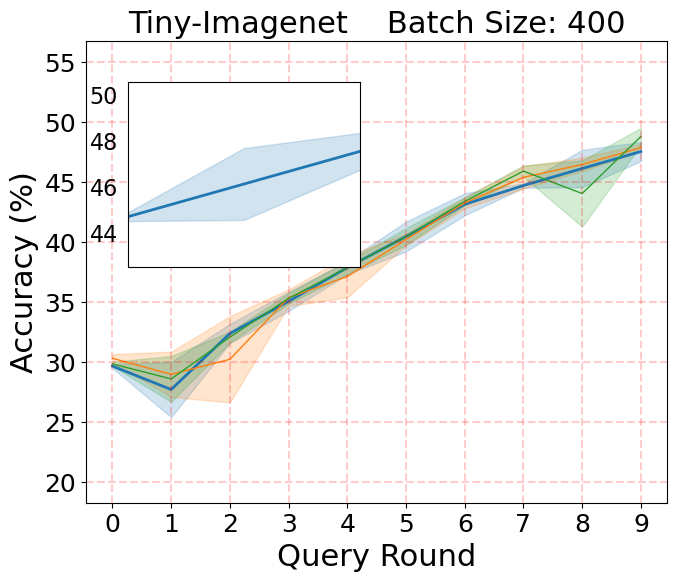

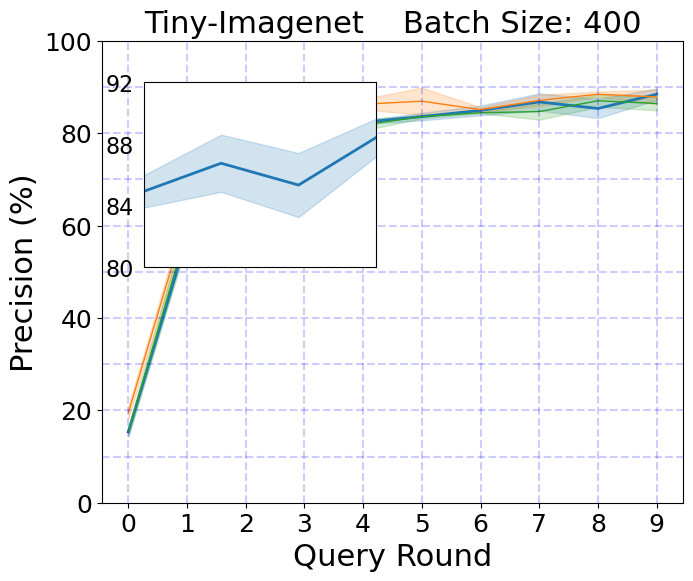

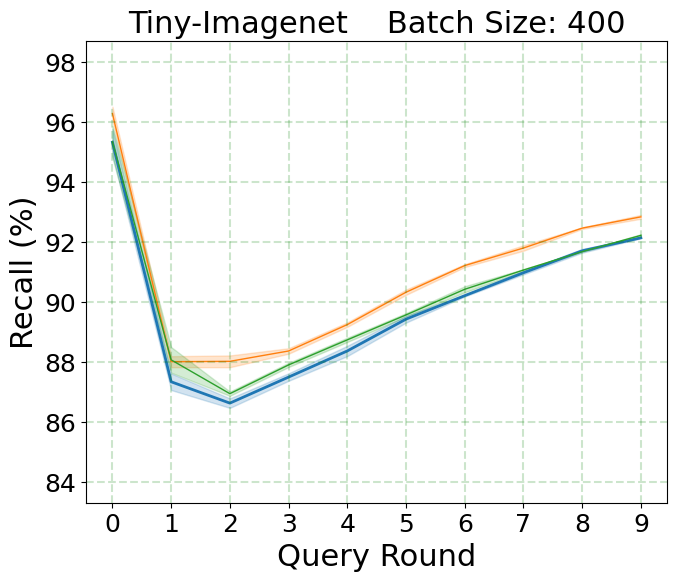

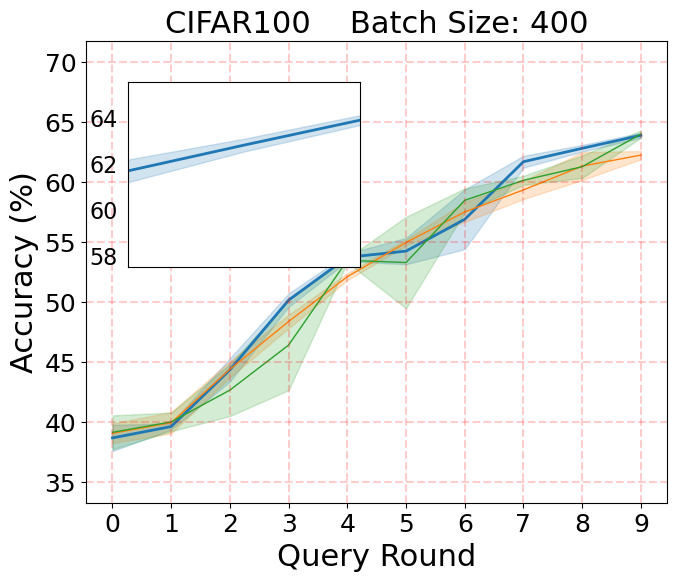

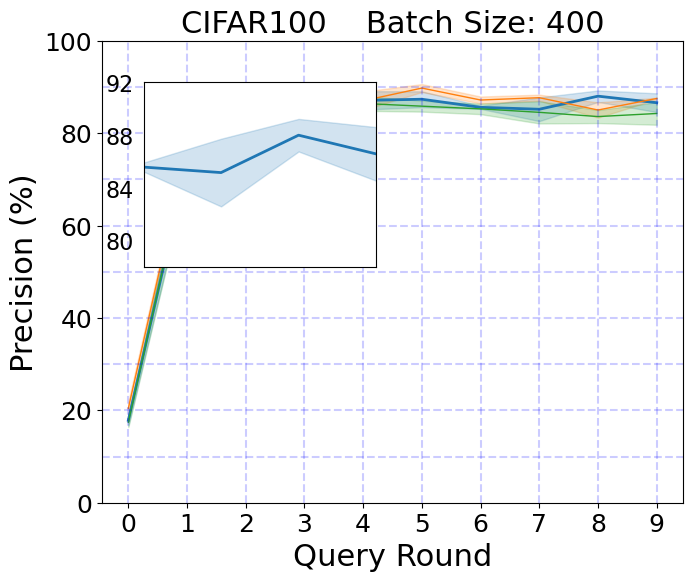

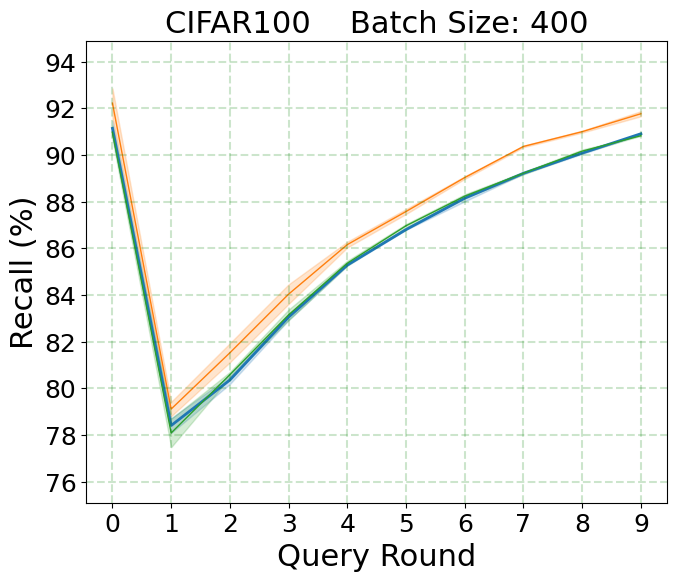

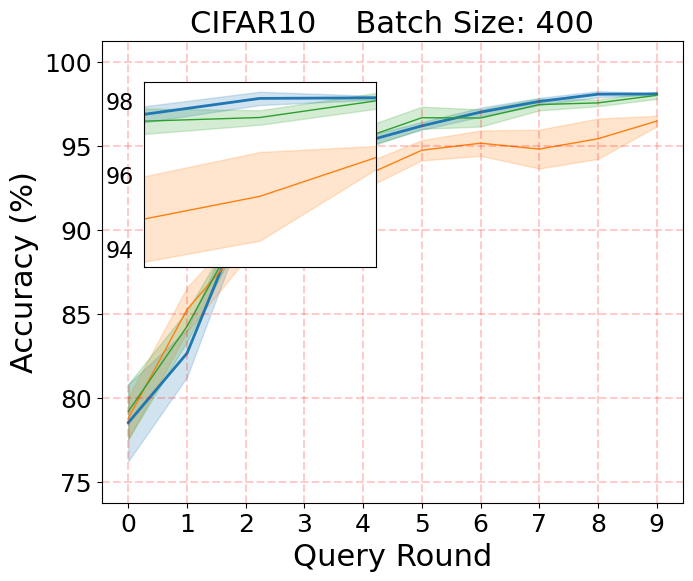

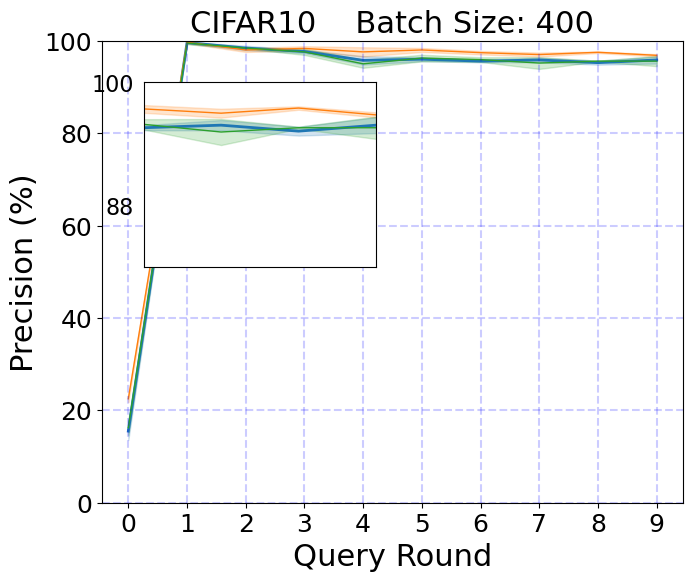

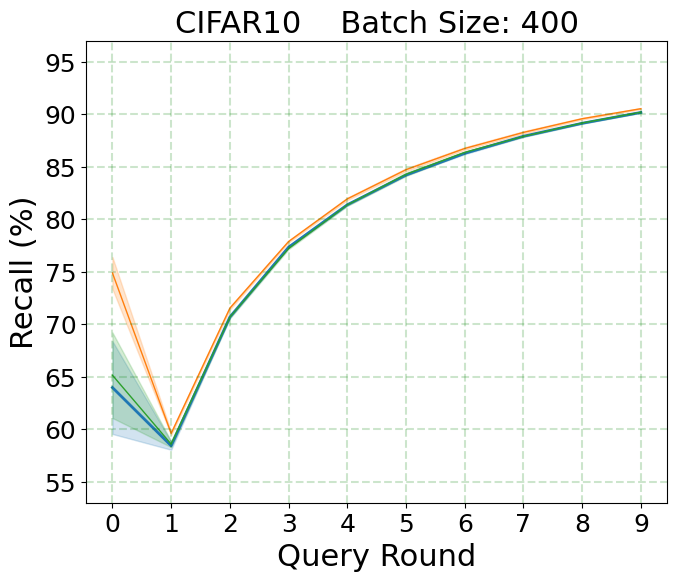

In [83]:
for dataset_name, dataset_info in datasets.items():
    for known_class in dataset_info['known_class']:
        for batch_size in dataset_info['batch']:
            group_name = f"{dataset_name} Known {known_class} Batch {batch_size}"
            pkl_files_dict = load_pkl_files(dataset_name, known_class, batch_size)
            acc_list, precision_list, recall_list = [], [], []
            acc_std_list, precision_std_list, recall_std_list = [], [], []

            for method, files in pkl_files_dict.items():
                acc_vals, precision_vals, recall_vals = [], [], []
                for file in files:
                    with open(file, 'rb') as f:
                        data = pickle.load(f)
                        acc_vals.append([data['Acc'][i] for i in data['Acc']])
                        precision_vals.append([data['Precision'][i] for i in data['Precision']])
                        recall_vals.append([data['Recall'][i] for i in data['Recall']])

                if acc_vals:
                    num_seeds = len(files)
                    acc_avg = np.mean(acc_vals, axis=0).tolist()
                    precision_avg = np.mean(precision_vals, axis=0).tolist()
                    recall_avg = np.mean(recall_vals, axis=0).tolist()

                    acc_std = np.std(acc_vals, axis=0).tolist()
                    precision_std = np.std(precision_vals, axis=0).tolist()
                    recall_std = np.std(recall_vals, axis=0).tolist()

                    acc_list.append(acc_avg)
                    precision_list.append(precision_avg)
                    recall_list.append(recall_avg)

                    acc_std_list.append(acc_std)
                    precision_std_list.append(precision_std)
                    recall_std_list.append(recall_std)

            plot_graphs(group_name, acc_list, precision_list, recall_list, acc_std_list, precision_std_list,
                        recall_std_list, batch_size)